In [106]:
import numpy as np
# import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
import pandas as pd
import scipy.special as SS
import scipy.stats as SSA
import copy
import random
import sys
from sklearn.model_selection import ParameterGrid
import gzip
import matplotlib.pyplot as plt

In [32]:
R0 = 2.5
r = 1

In [98]:
%%timeit
# x_cutoff = 100
# p = r/(R0+r)
# weights = np.zeros(x_cutoff)
# for i in range(x_cutoff):
#     temp1=SS.gamma(r+i)/(SS.gamma(r)*SS.gamma((i+1)))*np.power(p,r)*np.power((1-p),i)
#     weights[i] = temp1
# weights_n = weights/np.sum(weights)
tt1 = np.random.choice(len(weights_n), size = 100000 , p=weights_n)

4.38 ms ± 9.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [76]:
weights_n[-1]

9.755654775956727e-16

In [77]:
weights[-1]

9.755654775956703e-16

In [78]:
np.sum(tt1>35)

1285

In [134]:
# r, p = 5, 0.5  # number of successes and probability of success
x = np.arange(0, 100, 1)  # define the range of x values
pmf = SSA.nbinom.pmf(x, r, p)  # calculate the probability mass function

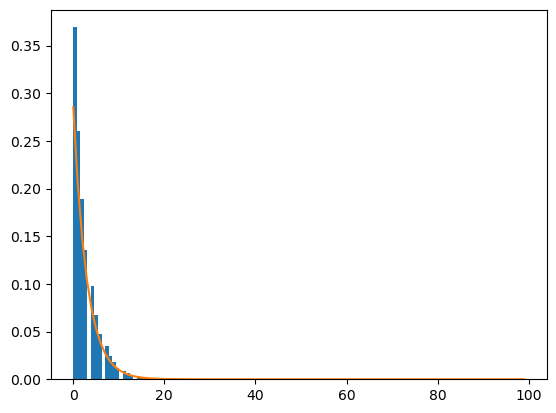

In [90]:
plt.hist(tt1, bins=40, density=True)
plt.plot(pmf)

In [133]:
# %%timeit
r = 50
p = r/(R0+r)
tt2 = np.random.default_rng().negative_binomial(r, p, 100000)

In [130]:
%%timeit
p = r/(R0+r)
tt3 = SSA.nbinom.rvs(r, p, size=100000, random_state=None)

6.32 ms ± 40.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


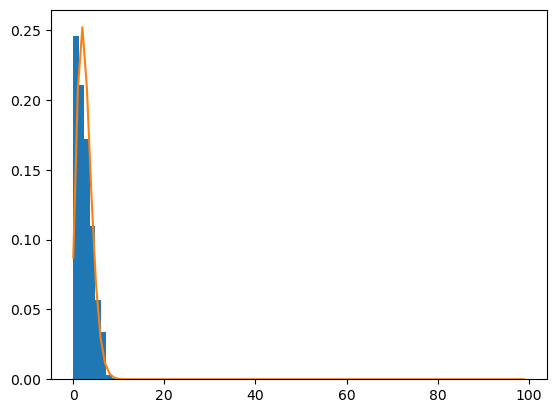

In [136]:
plt.hist(tt2, bins=10, density=True)
plt.plot(pmf)

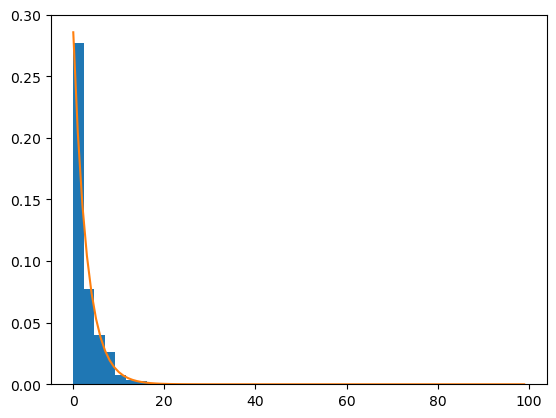

In [69]:
plt.hist(tt2, bins=20, density=True)
plt.plot(pmf)

In [100]:
import numpy as np
from scipy.stats import norm  # or whatever distribution you're using

# Create a SeedSequence
ss = np.random.SeedSequence(1234)

# Create a list to hold your random variates
random_variates = []

for _ in range(10):  # replace 10 with the number of simulations you want to run
    # Spawn a new Random Number Generator
    child_seeds = ss.spawn(1)
    rng = np.random.default_rng(child_seeds[0])
#     rng = np.random.default_rng(ss.spawn(1))

    # Generate random variates using this RNG
    rv = norm.rvs(size=100, random_state=rng)  # replace norm with your distribution
    random_variates.append(rv)

In [102]:
WN = np.loadtxt('W_avg.csv')
pop = np.loadtxt('pop_new.csv')

num_fips = len(pop)
T = 60
num_ens = 100 ##300 ###500 intially when R0 gets larger, we need fewer ensemble members, std is smaller

# pathogen characteristics
# initialize parameters

Z = 3 # latent period
Zb = 1 # scale parameter for Z
D = 5 # infectious period
Db = 1 # scale parameter for b
alpha = 0.1 # reporting rate 10%

#initialize variables
# seeding
l0 = 1859-1 # start with New York County NY in python -1, in matlab is 1859
i0 = 100 ## the starting t=0, in matlab it is 1
# initials = (l0,i0)

In [103]:
r = 0.1
R0 = 2.5

In [107]:
def get_new_infections_position(infectors, total_new, num_fips):
    cum_inft = np.cumsum(infectors)
    cum_new_infections = np.cumsum(total_new)

    totoal_new_infection_l = np.zeros(int(np.sum(total_new)))
    num_inft_s_idx = 0
    inft_s_idx = 0
    for l_indx in range(num_fips):
        num_inft = infectors[l_indx]
        if num_inft>0:
            num_inft_e_idx = num_inft_s_idx+num_inft
            infection_list_l = total_new[num_inft_s_idx:num_inft_e_idx] 
            ## the list of the number of infections caused by every infector
            num_ift_l = np.sum(infection_list_l)
            inft_e_idx = inft_s_idx + num_ift_l
            totoal_new_infection_l[int(inft_s_idx):int(inft_e_idx)] = l_indx
            ## the position of infection in the list of all infections
            num_inft_s_idx = num_inft_e_idx
            inft_s_idx = inft_e_idx
    return totoal_new_infection_l

In [199]:
%load_ext memory_profiler

In [288]:
r = 20
R0 = 2.5
p = r/(R0+r)

In [325]:
%%memit
ss = np.random.SeedSequence(1)
rand_seed = ss
NewInf = np.zeros((num_fips,T))
TotInf = np.zeros((num_fips,T))

NewInf[l0,0] = i0
TotInf[:,0] = NewInf[:,0]

child_seeds = rand_seed.spawn(T)

for ti in range(2):
    # print(ti)
    infectors = np.int64(NewInf[:,ti])
    total_num_infectors = np.sum(infectors)
    pop_immu = 1-TotInf[:,ti]/pop[:]
    pop_immu[pop_immu<0] = 0
    
    immu_all = [] ### create list of immu_prob * number of infectors
    for idx in range(len(pop_immu)):
        pop_immu_i  = [pop_immu[idx]]*infectors[idx]
        immu_all.extend(pop_immu_i)

    # tt = np.random.choice(len(weights_n), size = total_num_infectors , p=weights_n) ## this is a vector
    rng = np.random.default_rng(child_seeds[ti])
#     print(rng)
    tt = rng.negative_binomial(r, p, total_num_infectors)
    
    total_new = np.round(tt*immu_all) ### to be assigned, every new infections for the infector
    totoal_new_infection_loc = get_new_infections_position(infectors, total_new, num_fips)

    z_num = np.int64(np.sum(total_new))
    NF = np.zeros((2,z_num),dtype=np.int64)
    # for the time distribution
    latency_p = SSA.gamma.rvs(a = Z,scale=Zb,size = z_num,random_state=rng)
    infectious_p = SSA.gamma.rvs(a = D,scale=Db,size = z_num,random_state=rng)

    v = rng.random(z_num)
    delay_days = latency_p+v*infectious_p  #3+5*0.5


    NF[0,:] = np.ceil(delay_days+ti) ## make it idx int
    ## for the location distribution
    NF[1,:] = totoal_new_infection_loc
    df = pd.DataFrame(NF.T,columns=['time','o_l'])
    l_list = np.arange(num_fips)
    df['d_l'] = df['o_l'].apply(lambda x: np.random.choice(l_list, size = 1, p=WN[:,x])[0])
    df = df[df['time'] <= T-1]
    NF_ii = np.array(df)
    for (t,o,d) in NF_ii:
        NewInf[d,t] = NewInf[d,t]+1
    TotInf = np.cumsum(NewInf,axis=1)

peak memory: 658.73 MiB, increment: 0.00 MiB


In [312]:
%run ../codes/branchingv2.py

In [319]:
E_NewInf_i, E_TotInf_i = superspreading_T_Loc(60,num_fips,(l0,i0),(r,p),pop,(Z,Zb,D,Db),WN,ss)

In [320]:
E_NewInf_i.shape

(3142, 60)

In [321]:
np.sum(E_NewInf_i != 0)

3082

In [322]:
np.sum(E_TotInf_i != 0)

3734

In [198]:
np.repeat(pop_immu, infectors)

100

In [180]:
temp = copy.deepcopy(TotInf)

In [187]:
np.sum(temp != TotInf)

8973

In [109]:
over_rs = np.arange(0.02, 100, 0.02)

In [113]:
over_rs = np.array([ 0.02, 0.05, 0.1, 0.5, 1, 5, 10, 15, 20, 25, 30, 35, 40, 45])

In [119]:
# rs_selected = [0,1,2,3,4,5,6,25,49] ### select some r values
# rs = rs[rs_selected]
R0s = np.arange(1.5, 6.5, 0.1)
rs = np.array([20, 10., 2, 1, 0.5, 0.2, 0.1, 0.05, 0.025])
# R0s = R0s[7:] ### finish the rest of R0 values
param_grid = {'R0': R0s, 'r' : rs}
grid = ParameterGrid(param_grid)
para_dict = list(grid)

In [146]:
np.save('para_dict',para_dict)

In [208]:
para_dict[98]

{'R0': 2.500000000000001, 'r': 0.025}

In [206]:
np.load('para_dict.npy',allow_pickle=True)[89]

{'R0': 2.400000000000001, 'r': 0.025}

In [210]:
for i in range(90,99):
    R0 = para_dict[i]['R0']
    r = para_dict[i]['r']
    save_dir = '/rds/general/user/qy1815/ephemeral/branching_R0-{}_r-{}/' .format(np.round(R0,2),np.round(r,3))
    print(save_dir)

/rds/general/user/qy1815/ephemeral/branching_R0-2.5_r-20.0/
/rds/general/user/qy1815/ephemeral/branching_R0-2.5_r-10.0/
/rds/general/user/qy1815/ephemeral/branching_R0-2.5_r-2.0/
/rds/general/user/qy1815/ephemeral/branching_R0-2.5_r-1.0/
/rds/general/user/qy1815/ephemeral/branching_R0-2.5_r-0.5/
/rds/general/user/qy1815/ephemeral/branching_R0-2.5_r-0.2/
/rds/general/user/qy1815/ephemeral/branching_R0-2.5_r-0.1/
/rds/general/user/qy1815/ephemeral/branching_R0-2.5_r-0.05/
/rds/general/user/qy1815/ephemeral/branching_R0-2.5_r-0.025/


In [202]:
2400*50

120000

In [203]:
len(para_dict)

450

In [204]:
450*300

135000

In [336]:
f1 = gzip.GzipFile('NewInf_R0-2.5_r-20.0_1.npy.gz', "r")
xx1 = np.load(f1)

In [337]:
f2 = gzip.GzipFile('NewInf_R0-2.5_r-20.0_10.npy.gz', "r")
xx2 = np.load(f2)

In [339]:
np.sum(xx2 != 0)

3386